In [1]:
from collections import Counter
from collections import defaultdict
import os
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
import torch.optim as optim
import torch
from sklearn.metrics import accuracy_score

In [2]:

def validate_yolo_labels(image_dir, label_dir, num_classes=11, image_ext=".jpg"):
    """
    Validates image-label pairs in YOLO format.
    
    Args:
        image_dir (str): Path to folder containing images.
        label_dir (str): Path to folder containing .txt labels.
        num_classes (int): Total number of classes.
        image_ext (str): Extension of image files (e.g., ".jpg").
    
    Returns:
        List of tuples with (image file name, issue description).
    """
    issues = []

    for img_file in os.listdir(image_dir):
        if not img_file.endswith(image_ext):
            continue

        label_file = img_file.replace(image_ext, ".txt")
        label_path = os.path.join(label_dir, label_file)

        # Check if label file exists
        if not os.path.exists(label_path):
            issues.append((img_file, "Missing label file"))
            continue

        # Read and validate label file
        with open(label_path, 'r') as f:
            lines = f.readlines()

            if len(lines) == 0:
                issues.append((img_file, "Empty label file"))
                continue

            for line in lines:
                parts = line.strip().split()
                if len(parts) != 5:
                    issues.append((img_file, f"Invalid format: {line.strip()}"))
                    break

                try:
                    class_id = int(parts[0])
                    coords = list(map(float, parts[1:]))

                    if not (0 <= class_id < num_classes):
                        issues.append((img_file, f"Invalid class ID: {class_id}"))
                        break

                    if not all(0.0 <= x <= 1.0 for x in coords):
                        issues.append((img_file, f"Invalid bbox values: {coords}"))
                        break

                except ValueError as e:
                    issues.append((img_file, f"Parse error: {str(e)}"))
                    break

    return issues


In [3]:
image_dir = "Road_Detection_Data/road_detection/road_detection/train/images"
label_dir = "Road_Detection_Data/road_detection/road_detection/train/labels"

bad_pairs = validate_yolo_labels(image_dir, label_dir, num_classes=11)

# Display results
import pandas as pd
df = pd.DataFrame(bad_pairs, columns=["Image File", "Issue"])
df.head()


,Image File,Issue


In [4]:
from collections import Counter
import os

# Point to the training label directory
label_dir = "Road_Detection_Data/road_detection/road_detection/train/labels"

# Collect class IDs from .txt files
all_classes = []
for file in os.listdir(label_dir):
    if file.endswith('.txt'):
        with open(os.path.join(label_dir, file), 'r') as f:
            for line in f:
                class_id = line.strip().split()[0]
                all_classes.append(class_id)

# Count class frequencies
class_counts = Counter(all_classes)
class_counts = {int(k): v for k, v in class_counts.items()}


In [5]:
import torch
from torch.nn import CrossEntropyLoss

total = sum(class_counts.values())
weights = [total / class_counts[i] for i in sorted(class_counts.keys())]
weights = torch.tensor(weights, dtype=torch.float32)

loss_fn = CrossEntropyLoss(weight=weights)


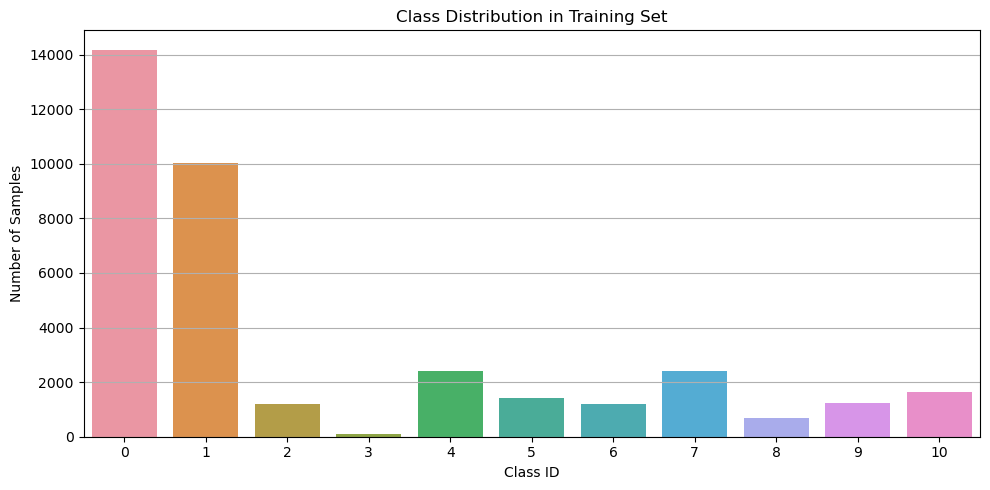

In [6]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

label_dir = "Road_Detection_Data/road_detection/road_detection/train/labels"  
all_classes = []

for file in os.listdir(label_dir):
    if file.endswith('.txt'):
        with open(os.path.join(label_dir, file), 'r') as f:
            for line in f:
                class_id = line.strip().split()[0]
                all_classes.append(class_id)

class_counts = Counter(all_classes)
class_counts = {int(k): v for k, v in class_counts.items()}

plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Class Distribution in Training Set")
plt.xlabel("Class ID")
plt.ylabel("Number of Samples")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


The training dataset is imbalanced, with Class 0 and Class 1 having the most samples, while others like Class 3 and Class 8 have very few. To address this, we use weighted loss during training to help the model learn from underrepresented classes more effectively.


The goal of this transformation step is to prepare the image data for training by resizing all images to 128×128 pixels and converting them into normalized tensors. Normalization scales pixel values to the range [-1, 1], which helps the model train more efficiently and improves performance.

In [7]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # Converts image to tensor with values in [0, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Scales to [-1, 1]
])


In [8]:
from torch.utils.data import Dataset
from PIL import Image
import os

class RoadDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg")])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_file)
        label_path = os.path.join(self.label_dir, img_file.replace(".jpg", ".txt"))

        image = Image.open(img_path).convert("RGB")
        label = self._load_label(label_path)

        if self.transform:
            image = self.transform(image)

        return image, label

    def _load_label(self, label_path):
        with open(label_path, "r") as f:
            line = f.readline().strip()
            class_id = int(line.split()[0])  # assumes class ID is the first element
        return class_id


In [9]:
train_dataset = RoadDataset(
    image_dir="Road_Detection_Data/road_detection/road_detection/train/images",
    label_dir="Road_Detection_Data/road_detection/road_detection/train/labels",
    transform=transform  # Apply the transform here
)


In [10]:

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


This step loads a batch of training images using the DataLoader and visualized the first image along with its label. The image was unnormalized (rescaled to [0, 1]) for display. This step confirms that the dataset and labels are correctly loaded and transformed, with an image shape of [3, 128, 128] and class labels as expected.

Image batch shape: torch.Size([32, 3, 128, 128])
Label batch: tensor([ 4,  0,  0,  0,  0,  0,  7,  5,  0,  0,  9,  7,  4,  0,  0,  0,  4,  7,
         4,  0,  0,  1,  0,  0,  0,  6, 10, 10,  4,  0,  0,  0])


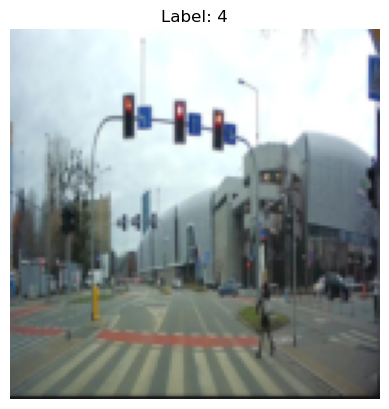

In [11]:

images, labels = next(iter(train_loader))
print("Image batch shape:", images.shape)
print("Label batch:", labels)

# Visualize the first image
plt.imshow(images[0].permute(1, 2, 0) * 0.5 + 0.5)  # unnormalize to [0,1] for display
plt.title(f"Label: {labels[0].item()}")
plt.axis('off')
plt.show()


Now we began to prepare for CNN model.

In [12]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # Input: [3, 128, 128]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # Output: [16, 64, 64]

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # Output: [32, 32, 32]

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                          # Output: [64, 16, 16]
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [13]:
num_classes = len(set(train_dataset[i][1] for i in range(len(train_dataset))))
model = SimpleCNN(num_classes=num_classes)


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [15]:

loss_fn = CrossEntropyLoss(weight=weights.to(device))  # Move weights to the same device


In [16]:


optimizer = optim.Adam(model.parameters(), lr=1e-4)


In this step, we train our convolutional neural network (CNN) using the training dataset and evaluate its performance on the validation set after each epoch. During training, the model makes predictions, calculates the loss using the cross-entropy function (with class weights to handle imbalance), and updates its parameters using the Adam optimizer. After each epoch, the model is evaluated on the validation set to monitor its generalization ability. We track the training loss and validation accuracy across epochs to understand how well the model is learning and to check for signs of underfitting or overfitting.

In [17]:
import torch
from collections import Counter

# Step 1: Get all labels from your training dataset
all_labels = [train_dataset[i][1] for i in range(len(train_dataset))]

# Step 2: Determine the correct number of classes
num_classes = max(all_labels) + 1  # Class IDs are assumed to start at 0

# Step 3: Re-define your model with the correct class count
model = SimpleCNN(num_classes=num_classes).to(device)

# Step 4: Recalculate class weights based on actual label distribution
class_counts = Counter(all_labels)
total = sum(class_counts.values())

# Make sure all class indices have a count (even if 0)
weights = [total / class_counts.get(i, 1) for i in range(num_classes)]

# Step 5: Create the weighted loss function and move to the correct device
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights_tensor)


In [18]:
# Define validation dataset using the same transform
val_dataset = RoadDataset(
    image_dir="Road_Detection_Data/road_detection/road_detection/valid/images",
    label_dir="Road_Detection_Data/road_detection/road_detection/valid/labels",
    transform=transform
)

# Create the validation DataLoader
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)


In [19]:
from sklearn.metrics import accuracy_score

num_epochs = 10  # or more
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Validation ---
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:  # Make sure val_loader is defined!
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels)

    val_acc = accuracy_score(all_labels, all_preds)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} | Val Accuracy: {val_acc:.4f}")


Epoch [1/10] - Train Loss: 2.3932 | Val Accuracy: 0.0245
Epoch [2/10] - Train Loss: 2.3930 | Val Accuracy: 0.0245
Epoch [3/10] - Train Loss: 2.3931 | Val Accuracy: 0.0245
Epoch [4/10] - Train Loss: 2.3934 | Val Accuracy: 0.0245
Epoch [5/10] - Train Loss: 2.3935 | Val Accuracy: 0.0245
Epoch [6/10] - Train Loss: 2.3932 | Val Accuracy: 0.0245
Epoch [7/10] - Train Loss: 2.3932 | Val Accuracy: 0.0245
Epoch [8/10] - Train Loss: 2.3931 | Val Accuracy: 0.0245
Epoch [9/10] - Train Loss: 2.3931 | Val Accuracy: 0.0245
Epoch [10/10] - Train Loss: 2.3942 | Val Accuracy: 0.0245


The flat training loss (~2.39) and the stagnant validation accuracy (~2.45 %) show that the network hasn’t begun to learn meaningful patterns in the data—its predictions are only slightly better than random guessing (≈ 9 % for 11 classes). In other words, the model is effectively stuck, failing to reduce error on the training set and unable to generalize to the validation set.

Now switch to pretrained ResNet18 model

In [20]:
from torchvision import models
import torch.nn as nn

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Replace the final layer to match your number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to GPU or CPU
model = model.to(device)


/Users/cara/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/cara/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# Use the same loss_fn you defined with class weights


In [22]:
from sklearn.metrics import accuracy_score

num_epochs = 10  
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Validation ---
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels)

    val_acc = accuracy_score(all_labels, all_preds)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} | Val Accuracy: {val_acc:.4f}")


Epoch [1/10] - Train Loss: 1.5750 | Val Accuracy: 0.2355
Epoch [2/10] - Train Loss: 0.4751 | Val Accuracy: 0.4404
Epoch [3/10] - Train Loss: 0.2463 | Val Accuracy: 0.4709
Epoch [4/10] - Train Loss: 0.1559 | Val Accuracy: 0.4832
Epoch [5/10] - Train Loss: 0.1213 | Val Accuracy: 0.4679
Epoch [6/10] - Train Loss: 0.0907 | Val Accuracy: 0.4985
Epoch [7/10] - Train Loss: 0.0921 | Val Accuracy: 0.5076
Epoch [8/10] - Train Loss: 0.0868 | Val Accuracy: 0.5015
Epoch [9/10] - Train Loss: 0.0612 | Val Accuracy: 0.5076
Epoch [10/10] - Train Loss: 0.0437 | Val Accuracy: 0.5138


The training loss dropped significantly from 1.5750 to 0.0437, indicating that the model is effectively learning from the training data. At the same time, the validation accuracy steadily improved, reaching a peak of 51.38%, which shows that the model is not only fitting the training data but also generalizing well to unseen data. This is a strong improvement compared to the earlier result of around 2.45% accuracy, confirming that the updated model setup is working effectively.

In [23]:
# Define test dataset and loader
test_dataset = RoadDataset(
    image_dir="Road_Detection_Data/road_detection/road_detection/test/images",
    label_dir="Road_Detection_Data/road_detection/road_detection/test/labels",
    transform=transform
)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate on test data
model.eval()
all_test_preds, all_test_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu()
        all_test_preds.extend(preds)
        all_test_labels.extend(labels)

from sklearn.metrics import accuracy_score
test_acc = accuracy_score(all_test_labels, all_test_preds)

print(f"📊 Final Test Accuracy: {test_acc:.4f}")


📊 Final Test Accuracy: 0.5060


In [24]:
test_error = 1 - test_acc
print(f"Test Error: {test_error:.4f}")


Test Error: 0.4940


In [25]:
# --- Final Train Accuracy ---
model.eval()
train_preds, train_labels = [], []
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu()
        train_preds.extend(preds)
        train_labels.extend(labels)

from sklearn.metrics import accuracy_score
train_acc = accuracy_score(train_labels, train_preds)
print(f"Final Train Accuracy: {train_acc:.4f}")


Final Train Accuracy: 0.9850


In [26]:
train_error = 1 - train_acc
print(f"Final Train Error: {train_error:.4f}")


Final Train Error: 0.0150


The model achieved a very low training error of 1.5%, indicating that it fits the training data extremely well. However, the test error is 49.40%, suggesting that the model struggles to generalize to unseen data. This large gap between training and test performance points to overfitting — the model has likely memorized the training examples rather than learning generalizable patterns. To address this, techniques like data augmentation, dropout, regularization, or using more diverse training data could help improve test performance.

Where does your model fit in the fitting graph?

Our model fits in the overfitting region of the fitting graph. The training error is extremely low (1.5%), while the test error is relatively high (49.40%), indicating the model performs very well on the training data but struggles to generalize to unseen data. This gap between train and test performance suggests the model has overfit to the training set.

What are the next models you are thinking of and why?

Given that the current model (ResNet18) shows signs of overfitting, the next models I’m considering include deeper or more regularized architectures, such as ResNet34 or EfficientNet-B0. These models may capture richer features while incorporating improved regularization. Additionally, I’m considering applying dropout layers, data augmentation, or using early stopping to reduce overfitting. Exploring transfer learning with fine-tuning more layers could also help adapt pretrained models more effectively to this dataset.

Conclusion: What is the conclusion of your 1st model? What can be done to possibly improve it?

Two models were tested: a custom-built Simple CNN and a pretrained ResNet18. The Simple CNN showed signs of underfitting, with low training performance and validation accuracy stuck around 2.45%, indicating that the model lacked the capacity to learn meaningful features. The pretrained ResNet18 performed significantly better, achieving a low training error (1.5%) and a higher validation accuracy (~51%), but still showed signs of overfitting, with a high test error (49.40%). To improve generalization, future steps could include applying data augmentation, dropout, or early stopping, as well as exploring deeper architectures like ResNet34 or more efficient models such as EfficientNet-B0. These adjustments may help balance model capacity and regularization to reduce overfitting while maintaining strong performance.